In [4]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

import itertools
import sqlite3

In [5]:
db = sqlite3.connect('results.sqlite3')

In [15]:
def fetch_run(run_name):
    runs = db.execute('SELECT run_id FROM runs WHERE name LIKE ?', (run_name,)).fetchall()
    if len(runs) > 1:
        raise ValueError('Ambiguous run name {} matches run ids {}'.format(run_name, runs))
    
    (run_id,), = runs
    data = db.execute('''
        SELECT channel, duty_cycle, voltage, voltage_stdev FROM measurements WHERE run_id == ?
        ''', (run_id,)).fetchall()
    
    grouped = {ch: [(duty, volt, stdev) for _ch, duty, volt, stdev in data]
               for ch, data in itertools.groupby(data, lambda elem: elem[0])}
    return grouped

In [76]:
def plot_run(name):
    data = fetch_run(name)
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.set_title('Run {}'.format(name))
    ax.set_xscale('log')
    min_x = min(duty for vals in data.values() for duty, volt, stdev in vals if duty > 0)
    ax.set_xlim([min_x*0.9, 1.1])
    ax.set_yscale('log')

    for ch in data:
        (cal_duty, cal_volt, _cal_stdev), *ch_data = data[ch]
        assert cal_duty == 0
        duty, volt, stdev = zip(*ch_data)
        #volt = np.array(volt) - cal_volt
        ax.errorbar(duty, volt, yerr=stdev)

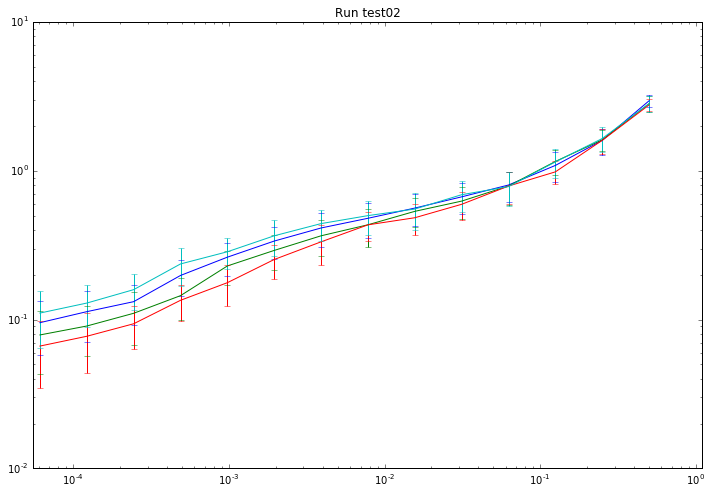

In [77]:
plot_run('test02')